# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [11]:
#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
<200 words

## ***Why?***
<200 words

## ***How?***
<400 words

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
<300 words

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]." <img src="data/loopdesign.png">

In [12]:
x = np.loadtxt("data/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [13]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ..., 
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [14]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [15]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [16]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([ 0.11666667,  0.245     ,  0.34083333,  0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[  8.   7.   3.   2.]
 [  9.  30.  13.   3.]
 [  2.   9.  42.  11.]
 [  1.   7.  14.  39.]]


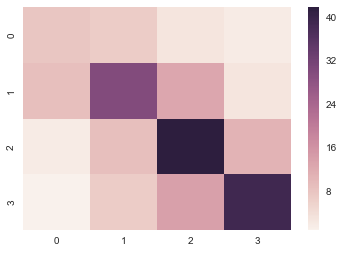

In [17]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [18]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.43864782658915019

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [19]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [20]:
krippendorffs_alpha(anno.annotations[::])

0.64725882238315469

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [21]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [22]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.43917037  0.47677621         nan         nan         nan
   0.45819119  0.43381462]
 [ 0.43917037  1.          0.38432922  0.41344423         nan         nan
          nan  0.33643611]
 [ 0.47677621  0.38432922  1.          0.39583333  0.51704894         nan
          nan         nan]
 [        nan  0.41344423  0.39583333  1.          0.34597068  0.4446844
          nan         nan]
 [        nan         nan  0.51704894  0.34597068  1.          0.37938644
   0.43039733         nan]
 [        nan         nan         nan  0.4446844   0.37938644  1.
   0.38341929  0.31214748]
 [ 0.45819119         nan         nan         nan  0.43039733  0.38341929
   1.          0.394806  ]
 [ 0.43381462  0.33643611         nan         nan         nan  0.31214748
   0.394806    1.        ]]


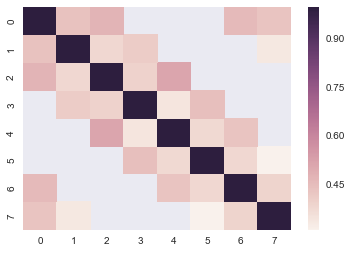

In [23]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [24]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [25]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.53302405078744974

Or averaged over the total:

In [26]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.52991134587171662

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

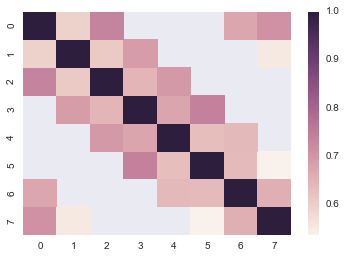

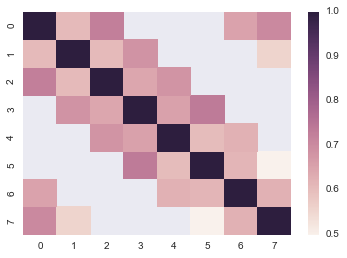

In [27]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [28]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.651721932118 0.63808488688


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Chalk, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [29]:
# create a new instance of model A, with 4 label classes
model = ModelA.create_initial_state(4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.75457383  0.81073221  0.71381543  0.62943998  0.60752364  0.69494874
  0.71118966  0.70960308]
-3716.34492027


Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [30]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79540626  0.73337799  0.76948268  0.71027261  0.7228185   0.71932352
  0.7578644   0.71249878]
-2817.5195919


In [31]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79461357  0.73221804  0.7685838   0.70889859  0.72174356  0.71814637
  0.75684786  0.71122839]
-2817.51364258


Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [32]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[ 0.02766983  0.37904487  0.26789555  0.32538974]
 [ 0.99572734  0.00142422  0.00142422  0.00142422]
 [ 0.00930562  0.10337016  0.87801861  0.00930562]
 ..., 
 [ 0.00956102  0.07876103  0.90211692  0.00956102]
 [ 0.00956102  0.00956102  0.90211692  0.07876103]
 [ 0.07876103  0.90211692  0.00956102  0.00956102]]


Let's turn the posterior of the first 100 samples into a heatmap.

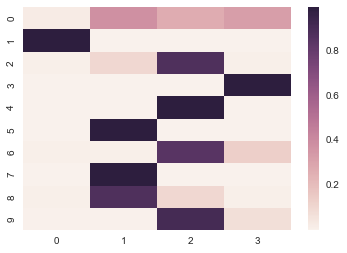

In [33]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [34]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
print(samples.mean(axis=0))
print(samples.std(axis=0))

[ 0.79977501  0.72641226  0.75677439  0.70733243  0.7037932   0.73558544
  0.75189615  0.70273667]
[ 0.03126631  0.03734029  0.03017829  0.03418996  0.02930187  0.03133712
  0.03728381  0.03092604]


Let's try everything again with ModelBt

In [35]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.69360595  0.73702075  0.75107119  0.79216356  0.78142092  0.85470697
  0.84451835  0.87988549]
-2902.13962694


In [36]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79127376  0.74081332  0.76229901  0.72516903  0.71650814  0.71857452
  0.77318604  0.7166806 ]
-2811.9463896


In [37]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[ 0.0111037   0.28920695  0.36503391  0.33465543]
 [ 0.99023002  0.00241714  0.00404651  0.00330633]
 [ 0.00249969  0.05507715  0.93459246  0.0078307 ]
 ..., 
 [ 0.00252911  0.04395501  0.94559301  0.00792287]
 [ 0.0024941   0.00571193  0.93250167  0.0592923 ]
 [ 0.03190011  0.93881493  0.01611646  0.0131685 ]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

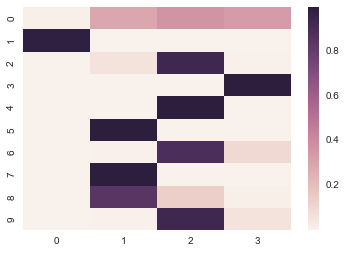

In [39]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [40]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[3, 3, 3],
       [2, 2, 2],
       [2, 0, 1],
       [3, 1, 1],
       [2, 2, 3],
       [2, 2, 2],
       [3, 2, 2],
       [1, 1, 1],
       [2, 2, 1],
       [0, 0, 1],
       [0, 0, 1],
       [3, 1, 0],
       [2, 2, 2],
       [0, 1, 1],
       [1, 1, 0],
       [0, 0, 3],
       [0, 0, 0],
       [0, 0, 2],
       [2, 2, 1],
       [0, 0, 1]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipyton notebook. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [41]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

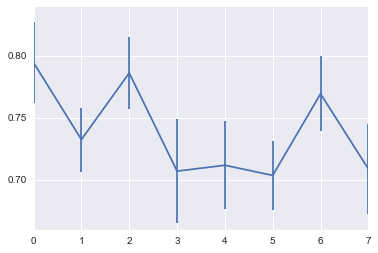

In [42]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Example with articles that use the General Social Survey

Getting the data for each content analysis survey regarding how GSS variables were used in a large population of social science articles.

In [43]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [44]:
dev.shape

(21461, 6)

In [45]:
anno_dv.labels

[0, 1]

In [46]:
anno_dv.missing_values

[-1]

In [47]:
anno_dv.annotations.shape

(21461, 6)

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [48]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[ 1.          0.62426874  0.46682841  0.44599604  0.16569888  0.36657805]
 [ 0.62426874  1.          0.53480937  0.52673854  0.3306905   0.59513211]
 [ 0.46682841  0.53480937  1.          0.50580068  0.42393752  0.49833997]
 [ 0.44599604  0.52673854  0.50580068  1.          0.46517493  0.47023754]
 [ 0.16569888  0.3306905   0.42393752  0.46517493  1.          0.66190749]
 [ 0.36657805  0.59513211  0.49833997  0.47023754  0.66190749  1.        ]]


Let's visualize that...

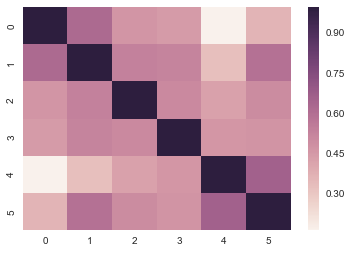

In [49]:
ax = seaborn.heatmap(m)
plt.show()

In [50]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

0.4721425844540702

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [51]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

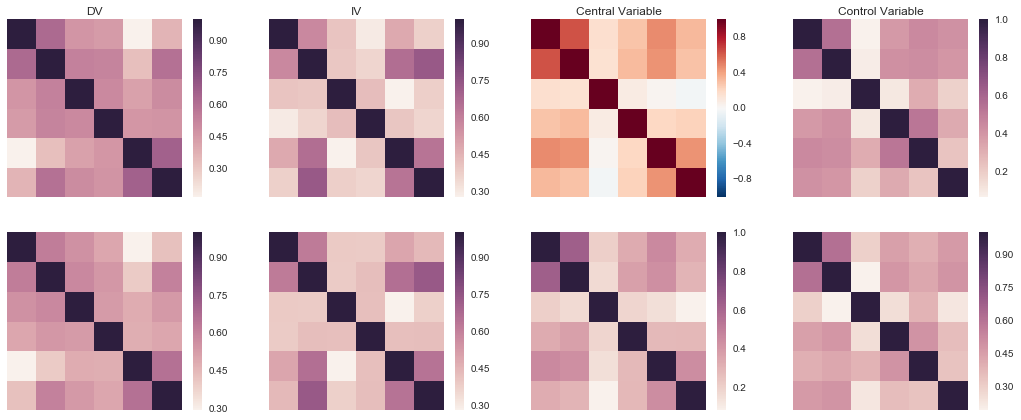

In [52]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Now we will compare the student coders.

In [53]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [54]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

0.472142584454
0.514240727822
0.45296278237
0.475965268669
0.270823768698
0.315140498284
0.328334778759
0.39458527792


Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [55]:
mergedata = np.loadtxt(fname="data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [56]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [57]:
print("""Dependent variable -- kappa & rho""")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Dependent variable -- kappa & rho
0.374431105795
0.385634372036

Independent variable
0.543069016464
0.552997494177

Central variable
-0.0640171895485
-0.0888764431926

Control variable
0.281517249918
0.282392375746


Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation)

Now for the assessment of the relative values of authors, then student coders.

In [58]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

Dependent
0.476391231029
0.358347386172

Independent
0.237774030354
0.313659359191

Central
0.35328836425
0.751264755481

Control
0.0817875210793
0.0944350758853


## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [59]:
dev.shape

(21461, 6)

In [60]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [61]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([ 0.7595594 ,  0.61024204,  0.86070324,  0.82659261,  0.81689305,
        0.85754749,  0.67945556,  0.76028128])

In [62]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[ 0.89613609  0.10386391]
-31078.5245775


In [63]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[ 0.69455487  0.30544513]
-25462.473635


In [64]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior)

[[ 0.0111037   0.28920695  0.36503391  0.33465543]
 [ 0.99023002  0.00241714  0.00404651  0.00330633]
 [ 0.00249969  0.05507715  0.93459246  0.0078307 ]
 ..., 
 [ 0.00252911  0.04395501  0.94559301  0.00792287]
 [ 0.0024941   0.00571193  0.93250167  0.0592923 ]
 [ 0.03190011  0.93881493  0.01611646  0.0131685 ]]


In [65]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [66]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)


Mean
[[[ 0.97904494  0.02095506]
  [ 0.51614092  0.48385908]]

 [[ 0.96920635  0.03079365]
  [ 0.2612621   0.7387379 ]]

 [[ 0.98292805  0.01707195]
  [ 0.34729234  0.65270766]]

 [[ 0.93555024  0.06444976]
  [ 0.24158093  0.75841907]]

 [[ 0.69311279  0.30688721]
  [ 0.04594872  0.95405128]]

 [[ 0.8654103   0.1345897 ]
  [ 0.06872153  0.93127847]]]

STD
[[[ 0.00228818  0.00228818]
  [ 0.01128318  0.01128318]]

 [[ 0.00342107  0.00342107]
  [ 0.01470245  0.01470245]]

 [[ 0.00321755  0.00321755]
  [ 0.01432504  0.01432504]]

 [[ 0.00533317  0.00533317]
  [ 0.01225791  0.01225791]]

 [[ 0.00772425  0.00772425]
  [ 0.00587914  0.00587914]]

 [[ 0.00693655  0.00693655]
  [ 0.00710317  0.00710317]]]


We will use Model B estimates for other variable assessments.

In [67]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

-130.737999116
[  9.20933481e-20   1.00000000e+00]
-48.9756711394
(48, 6)
(48, 2)
[[[ 0.80098486  0.19901514]
  [ 0.12444613  0.87555387]]

 [[ 0.80914137  0.19085863]
  [ 0.09169527  0.90830473]]

 [[ 0.80565941  0.19434059]
  [ 0.49847626  0.50152374]]

 [[ 0.80296465  0.19703535]
  [ 0.06728105  0.93271895]]

 [[ 0.80783582  0.19216418]
  [ 0.36515769  0.63484231]]

 [[ 0.80386946  0.19613054]
  [ 0.11776106  0.88223894]]]


In [68]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

-32830.2121582
[ 0.61093546  0.38906454]
-28620.6652325
(21461, 6)
(21461, 2)
[[[ 0.97046289  0.02953711]
  [ 0.3465753   0.6534247 ]]

 [[ 0.93656168  0.06343832]
  [ 0.05135013  0.94864987]]

 [[ 0.65764637  0.34235363]
  [ 0.20983598  0.79016402]]

 [[ 0.53494947  0.46505053]
  [ 0.02973543  0.97026457]]

 [[ 0.87435902  0.12564098]
  [ 0.09685236  0.90314764]]

 [[ 0.88957635  0.11042365]
  [ 0.08874911  0.91125089]]]
-35550.1294818
[ 0.23988844  0.76011156]
-25034.9185558
(21461, 6)
(21461, 2)
[[[ 0.89457874  0.10542126]
  [ 0.07049239  0.92950761]]

 [[ 0.78559283  0.21440717]
  [ 0.05856175  0.94143825]]

 [[ 0.99223291  0.00776709]
  [ 0.84207407  0.15792593]]

 [[ 0.95135769  0.04864231]
  [ 0.45663885  0.54336115]]

 [[ 0.68053036  0.31946964]
  [ 0.05744761  0.94255239]]

 [[ 0.5936195   0.4063805 ]
  [ 0.09577741  0.90422259]]]
-25643.0785095
[ 0.83068326  0.16931674]
-19415.7020352
(21461, 6)
(21461, 2)
[[[ 0.97115131  0.02884869]
  [ 0.34612686  0.65387314]]

 [[ 0.936947

Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [69]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

(21461, 2)
(21461, 2)
(21461, 2)
(21461, 2)


In [70]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) # posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [71]:
predicted_annotations.shape

(21461, 8)

In [72]:
np.savetxt("B_outputs.txt", predicted_annotations, delimiter='\t')

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?